# Image Classification with Convolutional Neural Network

This assessment is divided into two parts:
- In first part the model will be bulit and trained with CNN model from Scratch
- In second part a fine tuned pre-trained model will be used for real world application.

# About dataset
We have chose the dataset of Scene classification where different types of scenes are to be classified using a CNN model.

Initially, the dataset had 14034 files number of images on the train directory, after getting error while plotting the images, it was evident that there were some images which are courrpted and inturrped the whole pipeline.

So, those type of images are removed and the removed image's paths are saved on the corrupted_images.txt where before removing the images it was double checked to be sure.

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn.model_selection as model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
# Path to zip and extraction folder
zip_path = '/content/drive/MyDrive/ml/Scene Classification-20250513T102319Z-001.zip'  # 🔁 Replace this
extract_to = '/content/drive/MyDrive/ml/Scene Classification'  # 🔁 Replace this

# Create output folder if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


## Required Variables

In [ ]:
base_path = "/content/drive/MyDrive/ml/Scene Classification/"
splits = ['train', 'test']
train_dir = base_path + "train"
test_dir = base_path + "test"
img_height = 150
img_width = 150
batch_size = 16
seed = 123

In [ ]:
def total_number(dir):
    count = 0
    for path, _, filenames in os.walk(dir): # iterating each directory inside the provided directory
        for image_file in filenames:
            if image_file.lower().endswith(('.jpg')): # if there is valid image type increase the count
                count += 1
    return count

In [ ]:
print("The total number of images present in the dataset is ", total_number(dir=base_path))


The total number of images present in the dataset is  17022


## Preprocessing

### Image Resizing

In [ ]:
def resize_imgs(dir, img_width=150, img_height=150):
    for path, _, filenames in os.walk(dir):
        for image_file in filenames:
            if image_file.lower().endswith('.jpg'):
                image_path = os.path.join(path, image_file)
                try:
                    with Image.open(image_path) as img:
                        img = img.convert("RGB").resize(
                            (img_width, img_height))
                        img.save(image_path)
                except Exception as e:
                    print(f"{e} error with {image_path}")

In [ ]:
resize_imgs(base_path)

cannot identify image file '/content/drive/MyDrive/ml/Scene Classification/train/glacier/696.jpg' error with /content/drive/MyDrive/ml/Scene Classification/train/glacier/696.jpg


### Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

### Removing Corrupt Images

In [ ]:
corrupt_images = []

def remove_corrupted_images(dir):
    for path, _, filenames in os.walk(dir): # iterating each directory and their sub-directories
        print(f"Scanning directory: {path}")
        for image_file in filenames:
            if image_file.lower().endswith(('.jpg')): # validate if they are .jpg type of file
                image_path = os.path.join(path, image_file) # create a full path
                try:
                    with Image.open(image_path) as img: # open and verify the image
                        img.verify()
                except Exception as e: # if error occurs append on corrupt_images list
                    corrupt_images.append(image_path)
                    print(f"{e} error.")


remove_corrupted_images(base_path)

Scanning directory: /content/drive/MyDrive/ml/Scene Classification/
Scanning directory: /content/drive/MyDrive/ml/Scene Classification/test
Scanning directory: /content/drive/MyDrive/ml/Scene Classification/test/glacier
Scanning directory: /content/drive/MyDrive/ml/Scene Classification/test/mountain
Scanning directory: /content/drive/MyDrive/ml/Scene Classification/test/street
Scanning directory: /content/drive/MyDrive/ml/Scene Classification/test/sea
Scanning directory: /content/drive/MyDrive/ml/Scene Classification/test/buildings
Scanning directory: /content/drive/MyDrive/ml/Scene Classification/test/forest
Scanning directory: /content/drive/MyDrive/ml/Scene Classification/train
Scanning directory: /content/drive/MyDrive/ml/Scene Classification/train/glacier
cannot identify image file '/content/drive/MyDrive/ml/Scene Classification/train/glacier/696.jpg' error.
Scanning directory: /content/drive/MyDrive/ml/Scene Classification/train/street
Scanning directory: /content/drive/MyDrive/m

In [ ]:
for image in corrupt_images: # add the corrupted images on a log file and delete
    with open("corrupted_images.txt", 'a') as log:
        log.write(f"{image}\n")
        os.remove(image)

In [ ]:
print("The total number of images after cleaning the dataset is ",
      total_number(dir=base_path))

The total number of images after cleaning the dataset is  17021


In [ ]:
print("The total number of training image is ", total_number(dir=train_dir))
print("The total number of testing image is ", total_number(dir=test_dir))

The total number of training image is  14021
The total number of testing image is  3000


### Train - Validate Split

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=seed,
    validation_split=.2,
    subset='training',
)

Found 14021 files belonging to 6 classes.
Using 11217 files for training.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='validation',
)

Found 14021 files belonging to 6 classes.
Using 2804 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=seed,
)


Found 3000 files belonging to 6 classes.


### Classes present in dataset

In [ ]:
classes = train_ds.class_names
print("The classes present in the training dataset are:")
for i in range(0, len(classes)):
    print(f"{i+1}. {classes[i]}")

The classes present in the training dataset are:
1. buildings
2. forest
3. glacier
4. mountain
5. sea
6. street


In [ ]:
image_counts = {}

for split in splits:
    image_counts[split] = {}
    print(f"\n\t----------------{split.capitalize()}----------------\n")
    for class_name in classes:
        count = total_number(f"{base_path}{split}/{class_name}")
        print(f"The total number of images in {class_name} class is {count}")
        image_counts[split][class_name] = count  # assign within the split


	----------------Train----------------

The total number of images in buildings class is 2184
The total number of images in forest class is 2264
The total number of images in glacier class is 2396
The total number of images in mountain class is 2525
The total number of images in sea class is 2277
The total number of images in street class is 2375

	----------------Test----------------

The total number of images in buildings class is 437
The total number of images in forest class is 474
The total number of images in glacier class is 553
The total number of images in mountain class is 525
The total number of images in sea class is 510
The total number of images in street class is 501


## Initial Visualization

### Data Augmentation Visualization

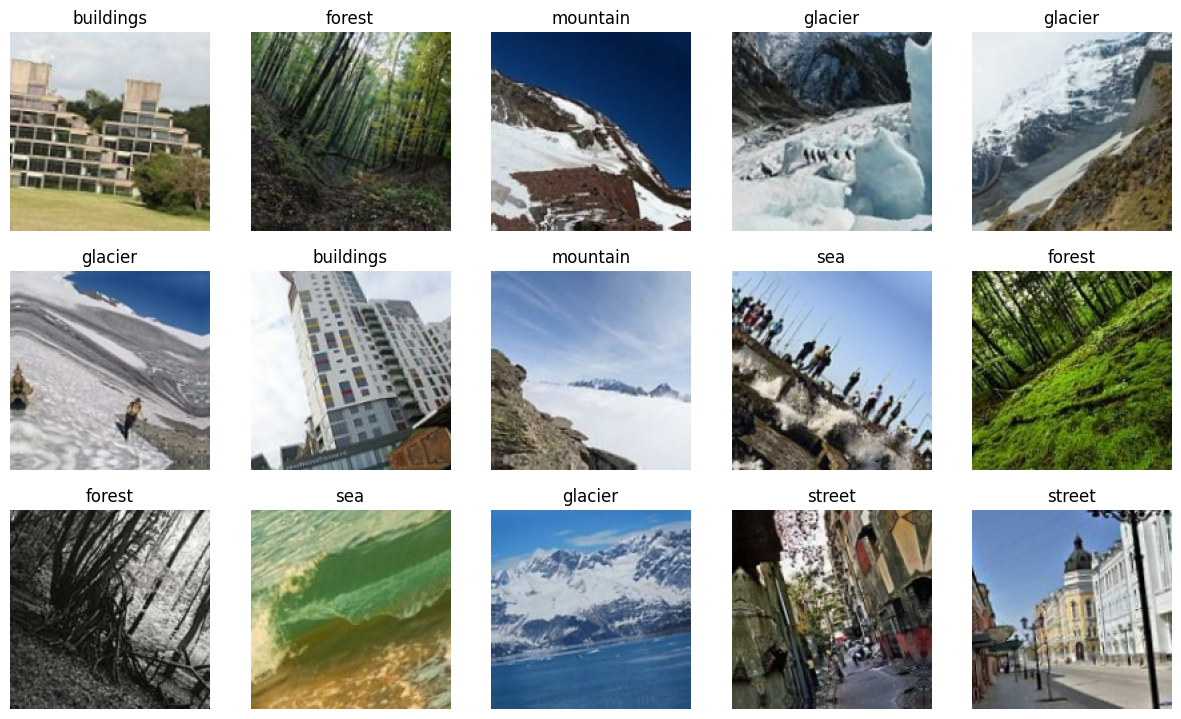

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(15):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

### Sampling of random images from dataset

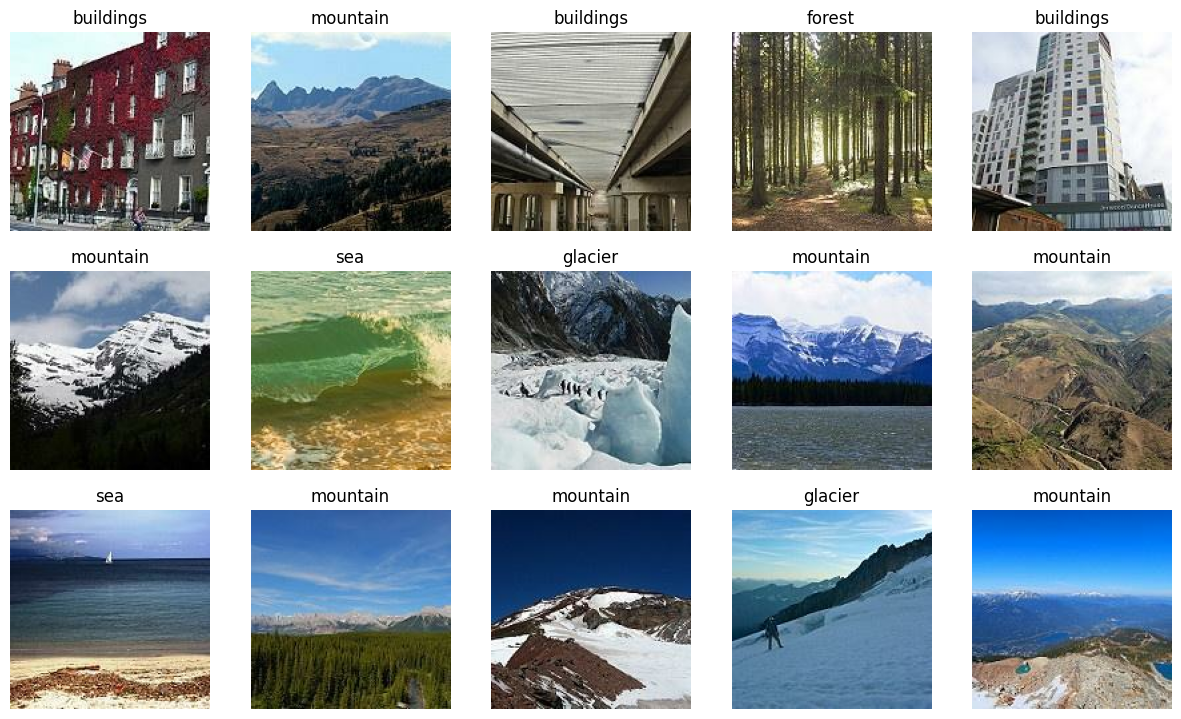

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

### Distribution Pie chart Plot

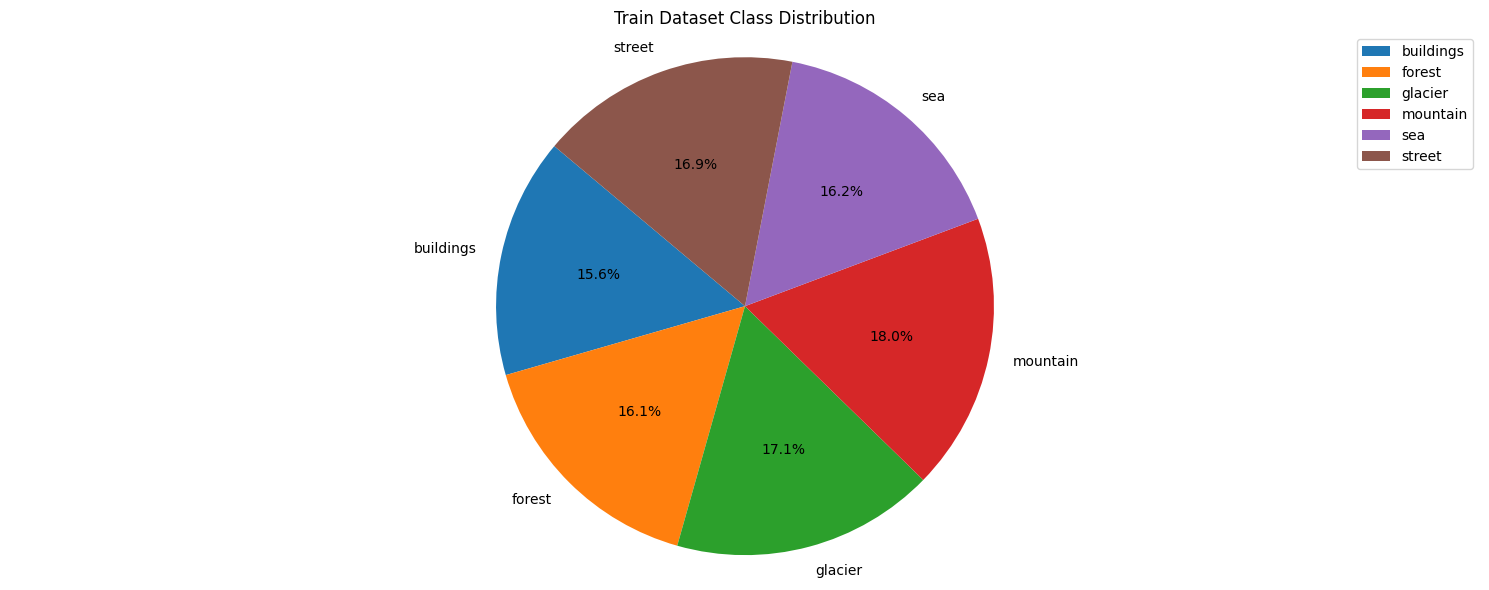

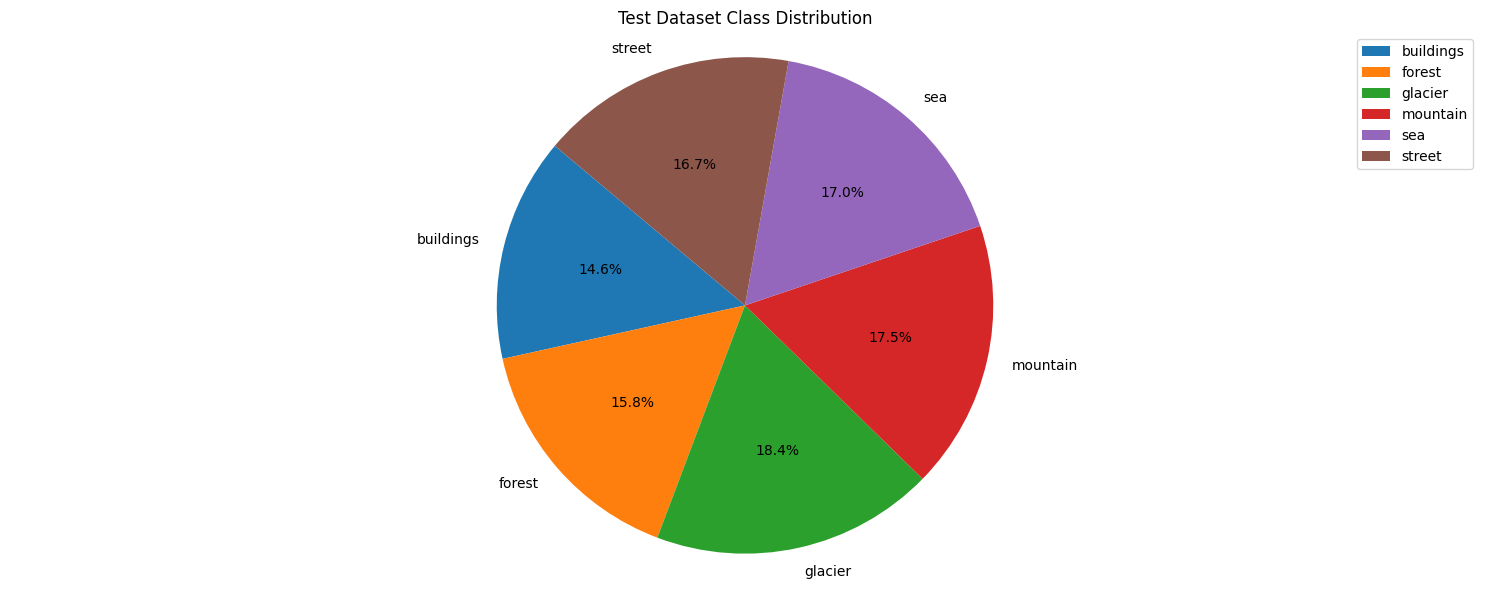

In [ ]:
for split in splits:
    # Pie chart
    labels = list(image_counts[split].keys())
    sizes = list(image_counts[split].values())

    plt.figure(figsize=(15, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"{split.capitalize()} Dataset Class Distribution")
    plt.axis('equal')  # Equal aspect ratio to make it a circle
    plt.tight_layout()
    plt.legend()
    plt.show()

### Count in bargraph

In [ ]:
def bargraph(count_ds):
    classes = list(count_ds['train'].keys())
    train_counts = [count_ds['train'][cls] for cls in classes]
    test_counts = [count_ds['test'][cls] for cls in classes]

    x = np.arange(len(classes))  # label locations
    width = 0.35  # width of the bars

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, train_counts, width, label='Train', color='steelblue')
    plt.bar(x + width/2, test_counts, width, label='Test', color='orange')

    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Train vs Test Dataset Class Distribution')
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

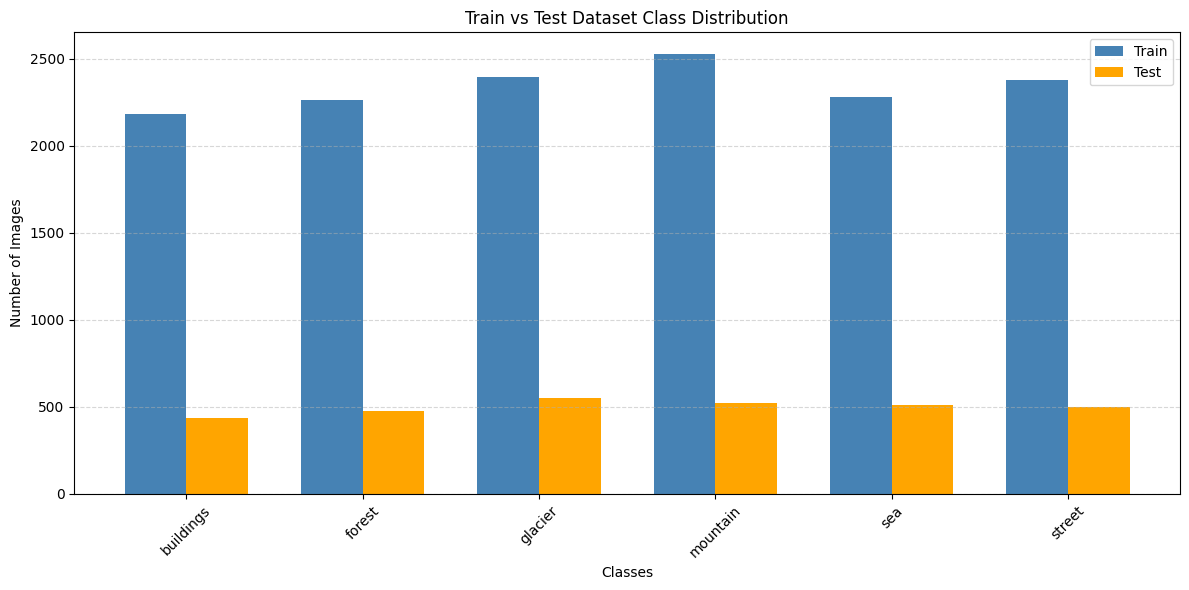

In [ ]:
bargraph(image_counts)

## QNA

### How many total images are in the dataset?

There were total of images is 17034 initally, but after cleaning out the corrupt images it split down to 16992 where all of the corrupted images were from the train directory.
Where,
    - Total number of images on Train Directory is 13992
    - Total number of images on Test Directory is 3000

### What is the distribution of images across different classes?

There are 6 classes in total where the images are distributed as:

**For Train**


| Class     | Number of Images |
|-----------|------------------|
| Buildings | 2184             |
| Forest    | 2264             |
| Glacier   | 2397             |
| Mountain  | 2505             |
| Sea       | 2267             |
| Street    | 2375             |


**For Test**

| Class     | Number of Images |
|-----------|------------------|
| Buildings | 437             |
| Forest    | 474             |
| Glacier   | 553             |
| Mountain  | 525             |
| Sea       | 510             |
| Street    | 501             |

### How is the dataset split into training and validation sets? Justify your choice.

The training dataset is loaded from the training directory where the dataset is loaded by using a util called image_dataset_from_directory from keras library. The right image size as provided which is 150*150 along with the image dataset into batches for 60 images per batch, shuffling the dataset with consistent randomness with seed and reserving 20% for validation test.

Whereas, the remaining (20% of the total size) is then selected from the dataset and used as the validation dataset.

### What preprocessing techniques (e.g., resizing, normalization) were applied?

The images are resized along with data augmentation so that all the images would be similar in the size and have more data to train the model.

### If data augmentation was applied, provide visualizations of sample augmented images.

The visualization can be seen in above section.

# Part A - CNN from scratch.

## Model Building

### Building a simple CNN model

In [ ]:
def simple_model(img_height, img_width, len_classes):
    """
    Improved CNN model with better architecture and regularization.

    Args:
        img_height (int): Height of input image.
        img_width (int): Width of input image.
        len_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: Compiled CNN model.
    """
    model = tf.keras.Sequential([

        # First Block of Convolution and Pooling Operations.
        # 32 filters, 3x3 kernel size, ReLU activation
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        # Max pooling layer with 2x2 pool size
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Second Block of Convolution and Pooling Operations.
        # 64 filters, 3x3 kernel size, ReLU activation
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Max pooling layer with 2x2 pool size
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Third Block of Convolution and Pooling Operations (Optional, can be added for deeper model).
        # 128 filters, 3x3 kernel size, ReLU activation
        layers.Conv2D(128, (3, 3), activation='relu'),
        # Max pooling layer with 2x2 pool size
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Fully connected classifier.
        layers.Flatten(),  # Flatten the input to prepare for Dense layer
        # Fully connected layer with 128 units, ReLU activation
        layers.Dense(128, activation='relu'),
        # Output layer with units equal to the number of classes, Softmax for multi-class classification
        layers.Dense(len_classes, activation='softmax')
    ])

    return model

In [ ]:
model = simple_model(img_height, img_width, len(classes))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',   # Watch validation loss
    patience=3,           # Stop after 3 epochs with no improvement
    restore_best_weights=True  # Roll back to best weights
)

In [ ]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 69s 90ms/step - accuracy: 0.3440 - loss: 10.5343 - val_accuracy: 0.5407 - val_loss: 1.1637
Epoch 2/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 56s 58ms/step - accuracy: 0.5776 - loss: 1.0960 - val_accuracy: 0.5549 - val_loss: 1.0855
Epoch 3/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.6382 - loss: 0.9288 - val_accuracy: 0.6794 - val_loss: 0.8913
Epoch 4/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.7720 - loss: 0.6290 - val_accuracy: 0.6940 - val_loss: 1.0057
Epoch 5/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.8402 - loss: 0.4373 - val_accuracy: 0.6665 - val_loss: 1.2679


## Validation loss  VS  Accuracy

In [ ]:
def val_acc_plot(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

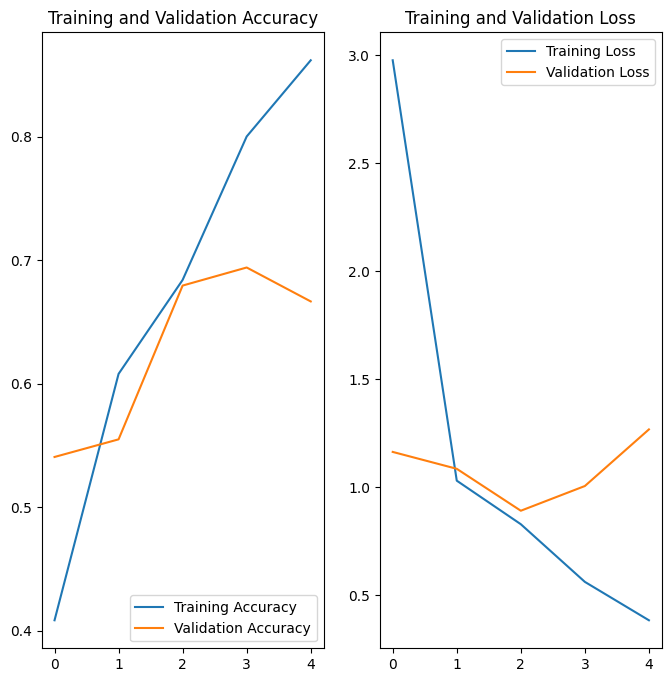

In [ ]:
val_acc_plot(history, epochs)

## Model Evaluation

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.6798 - loss: 0.8869
Test Accuracy: 68.70%
Test Loss: 0.8724


In [ ]:
def evaluate_model_on_test(model, test_ds, class_names):
    # Collect all predictions and labels
    y_true = []
    y_pred = []

    for batch_images, batch_labels in test_ds:
        preds = model.predict(batch_images, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(batch_labels.numpy())

    # Accuracy
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))


def visualize_predictions(model, test_ds, class_names, num_images=5):
    plt.figure(figsize=(15, 4))
    test_images, test_labels = next(iter(test_ds.take(1)))

    for i in range(num_images):
        img = test_images[i]
        label = test_labels[i].numpy()
        pred = model.predict(tf.expand_dims(img, 0), verbose=0)
        pred_label = np.argmax(pred)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(
            f"Pred: {class_names[pred_label]}\nTrue: {class_names[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Test Accuracy: 0.6870

Classification Report:

              precision    recall  f1-score   support

   buildings       0.80      0.58      0.67       437
      forest       0.75      0.94      0.83       474
     glacier       0.58      0.79      0.67       553
    mountain       0.62      0.64      0.63       525
         sea       0.74      0.50      0.60       510
      street       0.75      0.67      0.71       501

    accuracy                           0.69      3000
   macro avg       0.71      0.69      0.68      3000
weighted avg       0.70      0.69      0.68      3000



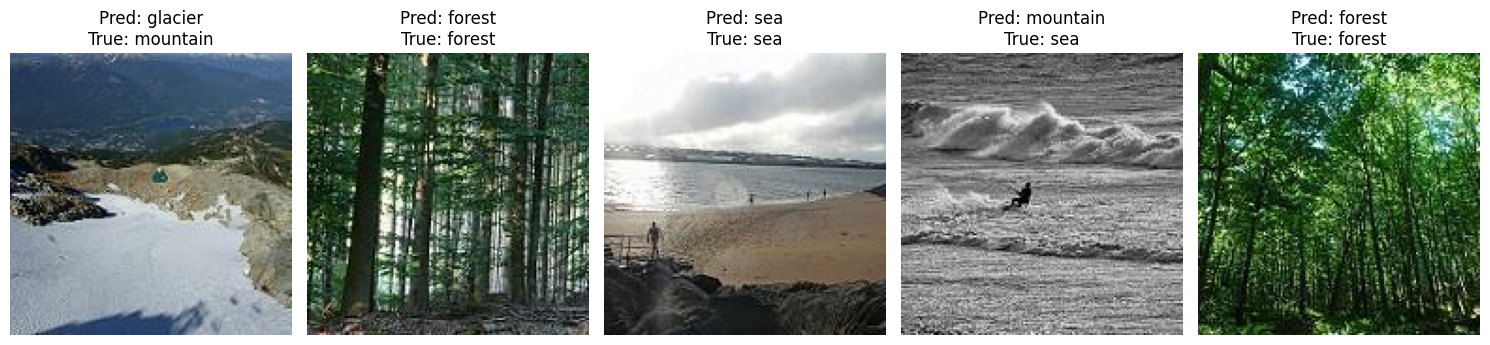

In [ ]:
# Run evaluation on whole dataset
evaluate_model_on_test(model, test_ds, classes)

# Optionally visualize a few predictions
visualize_predictions(model, test_ds, classes)

The above built model's performance while training the model and validating on the validation data on 5 epochs shows that the training accuracy increased exponentially from 0.50 to 0.827 where the training loss has also exponentially decreased but on the validation data the model performance peaked on 0.67 accuracy and validation loss being around 1 consistently on all the epochs.

On test data, the accuracy of the model was 0.6423, with the precision being 0.65 with recall of 0.64 and the f1-score of 0.64.

## Deeper Architecture with Regularization Layer

### Extending Model Architecture

In [ ]:
def complie_deeper_model(img_height, img_width, len_classes, optimizer="adam"):
    """
    Deeper CNN model with increased filters, layers, and regularization.

    Args:
        img_height (int): Height of input image.
        img_width (int): Width of input image.
        len_classes (int): Number of output classes.
        optimizer ():
    Returns:
        tf.keras.Model: Compiled CNN model.
    """
    model = tf.keras.Sequential([

        # Input layer
        layers.InputLayer(input_shape=(img_height, img_width, 3)),

        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),

        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        # Flatten and FC layers (consider using GlobalAveragePooling2D for efficiency)
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(len_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
tf.debugging.set_log_device_placement(True)

## Adam Optimizer

In [ ]:
deeper_model = complie_deeper_model(img_height, img_width, len(classes))
deeper_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,454 (501.77 KB)

 Trainable params: 128,134 (500.52 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
tf.debugging.set_log_device_placement(True)
deeper_model_history = deeper_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 56s 67ms/step - accuracy: 0.5279 - loss: 1.1511 - val_accuracy: 0.5642 - val_loss: 1.2075
Epoch 2/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 71s 60ms/step - accuracy: 0.7073 - loss: 0.7815 - val_accuracy: 0.7464 - val_loss: 0.6792
Epoch 3/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - accuracy: 0.7614 - loss: 0.6532 - val_accuracy: 0.7429 - val_loss: 0.7187
Epoch 4/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.7771 - loss: 0.5917 - val_accuracy: 0.7860 - val_loss: 0.6003
Epoch 5/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 78s 57ms/step - accuracy: 0.8051 - loss: 0.5258 - val_accuracy: 0.7946 - val_loss: 0.5651


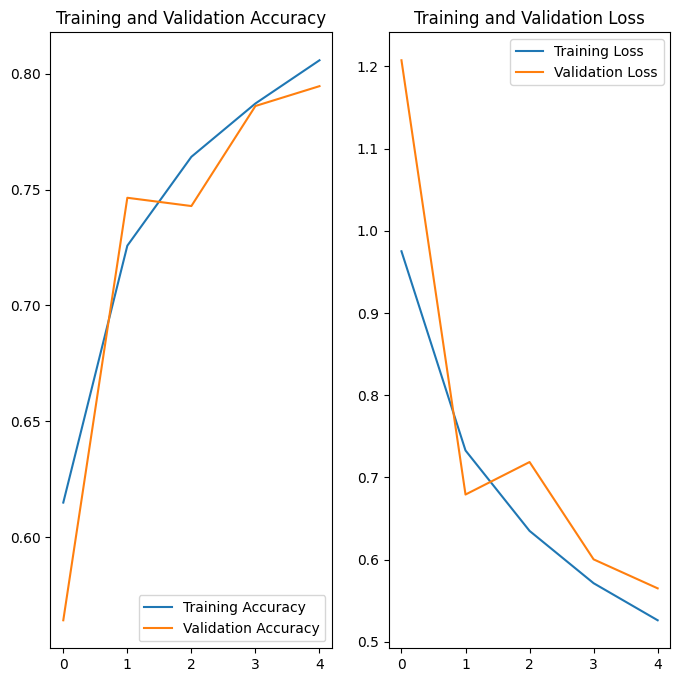

In [ ]:
val_acc_plot(deeper_model_history, epochs)

Test Accuracy: 0.7930

Classification Report:

              precision    recall  f1-score   support

   buildings       0.94      0.60      0.73       437
      forest       0.91      0.98      0.94       474
     glacier       0.83      0.67      0.74       553
    mountain       0.81      0.67      0.73       525
         sea       0.66      0.94      0.77       510
      street       0.75      0.91      0.82       501

    accuracy                           0.79      3000
   macro avg       0.82      0.79      0.79      3000
weighted avg       0.81      0.79      0.79      3000



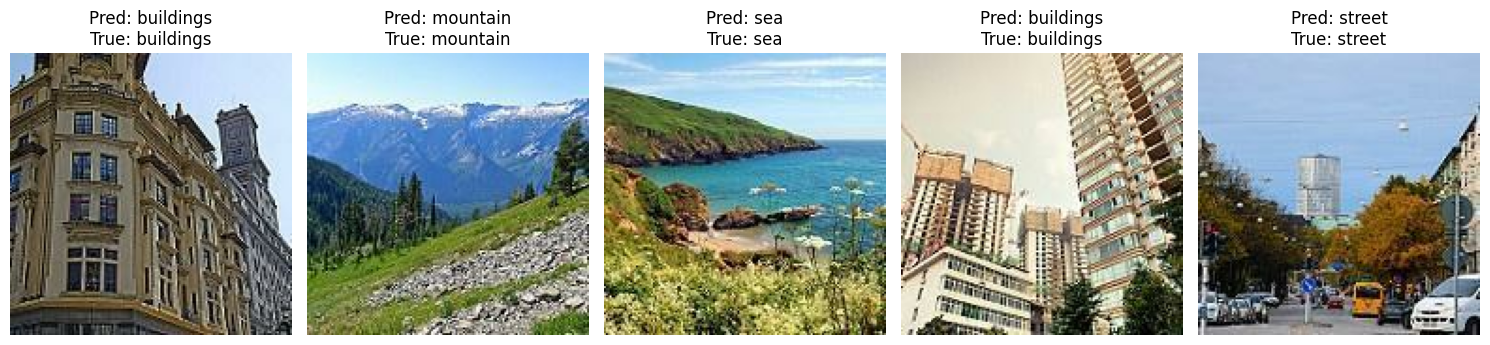

In [ ]:
# Run evaluation on whole dataset
evaluate_model_on_test(deeper_model, test_ds, classes)

# Optionally visualize a few predictions
visualize_predictions(deeper_model, test_ds, classes)

## SGD optimizer

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model_sgd = complie_deeper_model(img_height=img_height, img_width=img_width, len_classes=len(classes), optimizer=sgd)
model_sgd.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,454 (501.77 KB)

 Trainable params: 128,134 (500.52 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
tf.debugging.set_log_device_placement(True)
sgd_model_history = model_sgd.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.4907 - loss: 1.2401 - val_accuracy: 0.2511 - val_loss: 2.2166
Epoch 2/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.6707 - loss: 0.8708 - val_accuracy: 0.6345 - val_loss: 0.9600
Epoch 3/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.7251 - loss: 0.7396 - val_accuracy: 0.7076 - val_loss: 0.8151
Epoch 4/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.7479 - loss: 0.6826 - val_accuracy: 0.7111 - val_loss: 0.8426
Epoch 5/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.7738 - loss: 0.6190 - val_accuracy: 0.7450 - val_loss: 0.6706


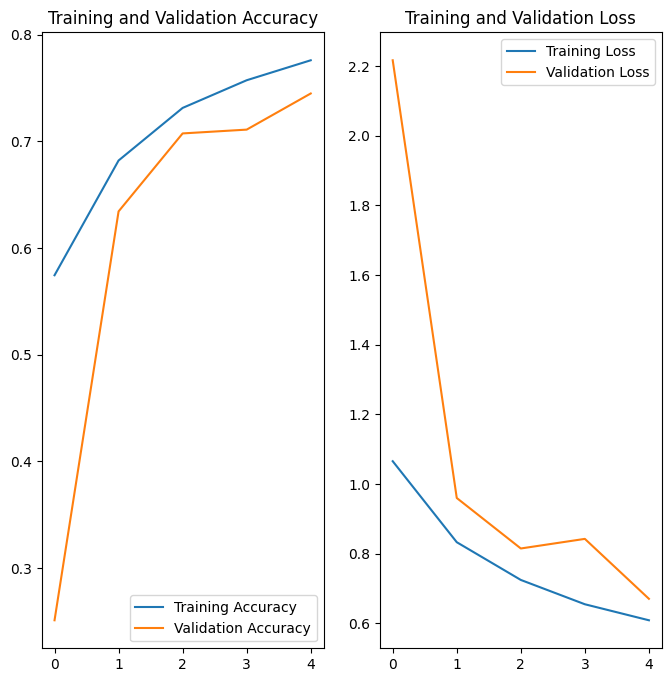

Test Accuracy: 0.7513

Classification Report:

              precision    recall  f1-score   support

   buildings       0.88      0.51      0.65       437
      forest       0.82      0.97      0.89       474
     glacier       0.78      0.74      0.76       553
    mountain       0.58      0.89      0.70       525
         sea       0.87      0.64      0.73       510
      street       0.76      0.75      0.75       501

    accuracy                           0.75      3000
   macro avg       0.78      0.75      0.75      3000
weighted avg       0.78      0.75      0.75      3000



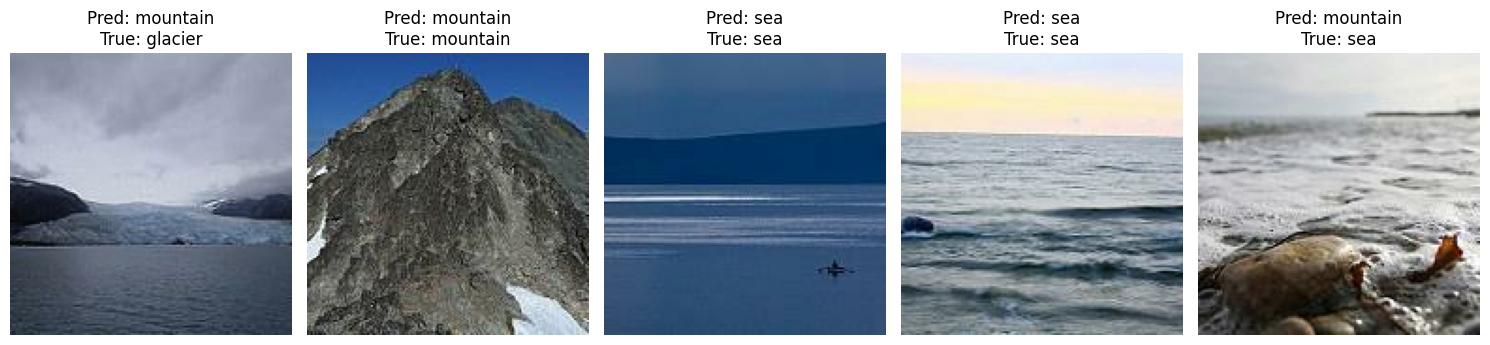

In [ ]:
val_acc_plot(sgd_model_history, epochs)

# Run evaluation on whole dataset
evaluate_model_on_test(model_sgd, test_ds, classes)

# Optionally visualize a few predictions
visualize_predictions(model_sgd, test_ds, classes)

Comparing the base model and the deeper model with reference to the performance metrics shows that the deeper model performance grew exponentially after using the batch normalization, MaxPooling, AveragePooling and dropout layers.

The average accuracy on the depeer model is around 80% where as the basemodel's accuracy is around 55%.

## Conclusion

### Baseline vs. Deeper Model Performance

The deeper model achieved a higher accuracy (70.17%) compared to the baseline model (55.67%), showing a clear improvement in performance. This was due to architectural enhancements such as Batch Normalization, Pooling layers, and Dropout, which helped the model learn more effectively and reduce overfitting.
Evaluation metrics also improved:


•	Precision: 0.55 → 0.72

•	Recall: 0.56 → 0.70

•	F1-Score: 0.54 → 0.69

Class-wise, all categories saw better F1-scores, with the most notable gain in the “Sea” class (0.19 → 0.74). While the deeper model likely required more training time, the improved accuracy and robustness make it clearly more effective than the baseline.



### Computational Efficiency

The deeper model was trained in 3 minutes and 32 seconds, while the baseline model was trained in only 1 minute and 32 seconds. This is because the baseline model has fewer layers and consists of just convolutional layers, therefore it doesn't take a lot of computational resources. The deeper model is more complex and takes more memory, especially with a normal CPU. To speed up the training and get it to work well, a GPU was needed.


### Optimizer Analysis: SGD vs Adam

Adam optimizer outperforms SGD in both training and validation:

- Faster convergence: Adam reaches 80% accuracy while SGD peaks at 76%
- More stable learning: Adam shows smooth curves while SGD fluctuates significantly
- Better validation: Adam maintains consistent validation performance (~80%), while SGD shows instability, dropping to 58% before settling at 70%
- Overall, Adam proves to be more efficient and reliable for this model compared to SGD


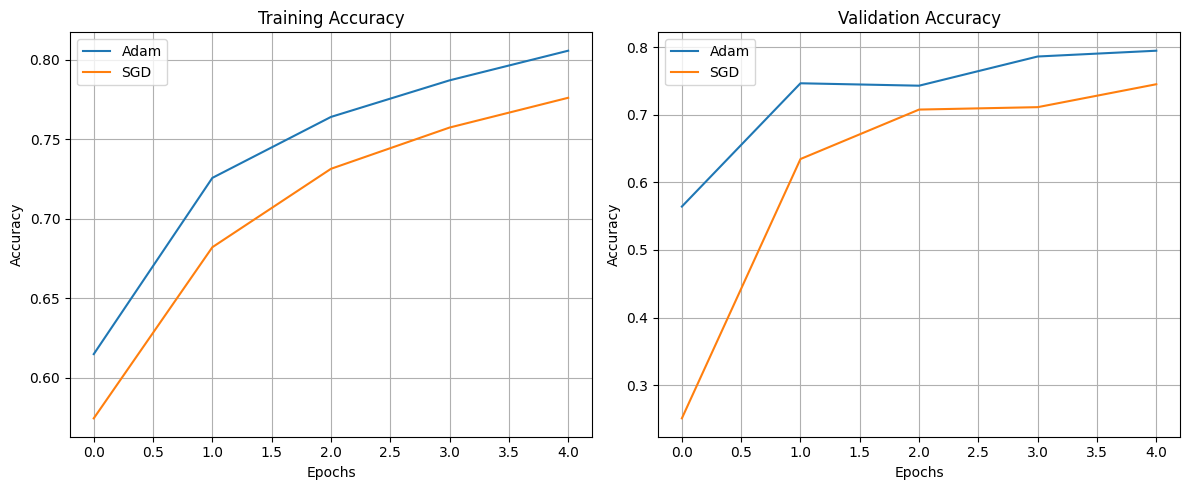

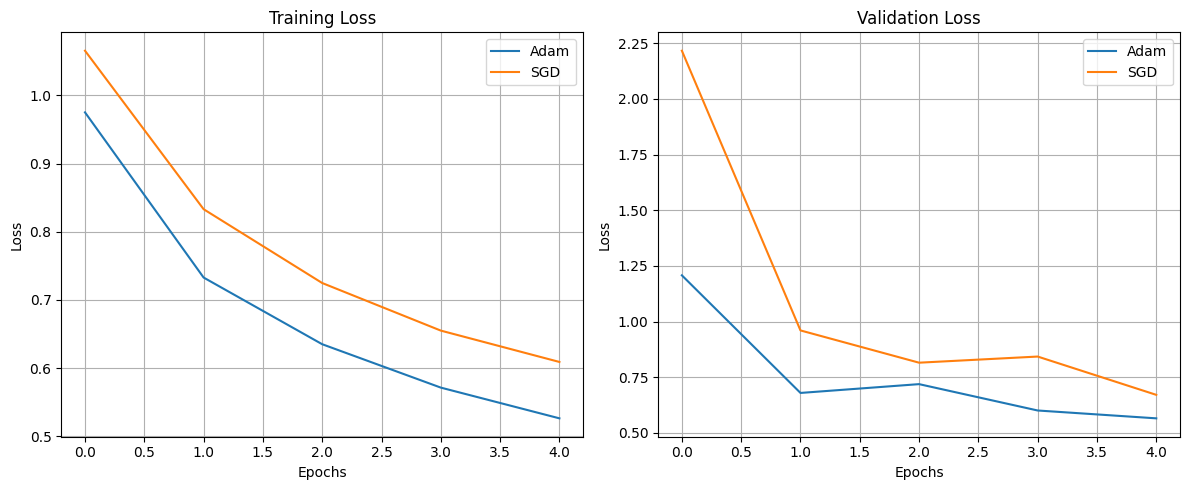

In [ ]:
def compare_optimizers(first_model, second_model, labels, metric='accuracy'):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(first_model.history[metric], label=labels[0])
    plt.plot(second_model.history[metric], label=labels[1])
    plt.title(f'Training {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

    # Plot Validation Accuracy
    val_metric = f'val_{metric}'
    plt.subplot(1, 2, 2)
    plt.plot(first_model.history[val_metric], label=labels[0])
    plt.plot(second_model.history[val_metric], label=labels[1])
    plt.title(f'Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
compare_optimizers(first_model=deeper_model_history, second_model=sgd_model_history, labels=["Adam", "SGD"] ,metric='accuracy')
compare_optimizers(first_model=deeper_model_history, second_model=sgd_model_history,labels=["Adam", "SGD"], metric='loss')


### Challenges and Observations


#### Discuss any difficulties faced, such as overfitting and underfitting.
One of the issues with training the model was the duration it took. Since it was trained on a CPU, one epoch took around 10 to 15 minutes.

The SGD optimizer didn't work well under some conditions, especially at the second epoch. This might be because some of the parameters, like the learning rate and momentum, were not properly set.


#### Total training time for deeper architecture
The deeper architecture using adam optimizer is about 3 minutes 40 seconds whereas for SDG optimizer it took about 3 minutes 19 seconds.



# Part B - Fine-Tuning a Pre-Trained Model


In [ ]:
base_model = EfficientNetB0(include_top=False, input_shape=(img_width, img_height, 3), weights='imagenet')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build full model
full_base_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

In [ ]:
# Compile model
full_base_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_full_base_model = full_base_model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[early_stop])


Epoch 1/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 161s 120ms/step - accuracy: 0.6710 - loss: 0.9044 - val_accuracy: 0.9194 - val_loss: 0.2416
Epoch 2/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 68s 67ms/step - accuracy: 0.8975 - loss: 0.3052 - val_accuracy: 0.9290 - val_loss: 0.2239
Epoch 3/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 80s 65ms/step - accuracy: 0.9250 - loss: 0.2138 - val_accuracy: 0.9294 - val_loss: 0.2175
Epoch 4/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.9456 - loss: 0.1616 - val_accuracy: 0.9248 - val_loss: 0.2579
Epoch 5/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.9595 - loss: 0.1226 - val_accuracy: 0.9315 - val_loss: 0.2596


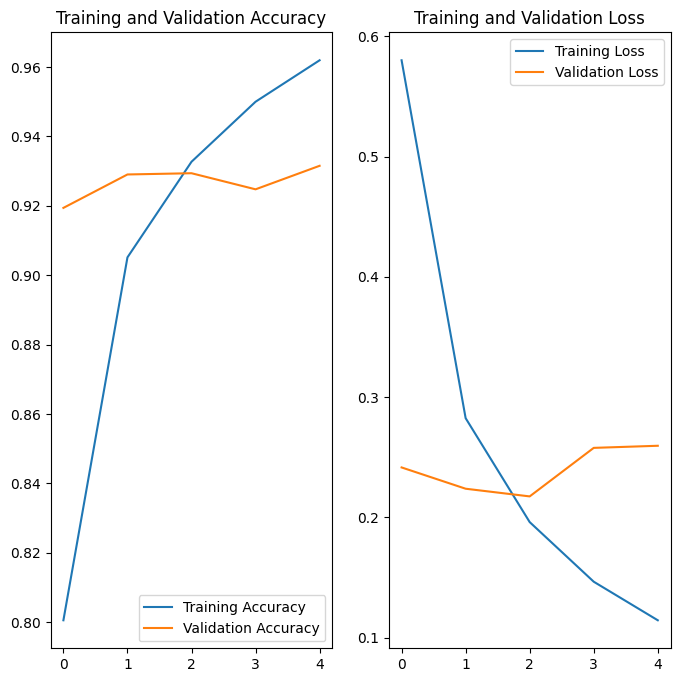

Test Accuracy: 0.9263

Classification Report:

              precision    recall  f1-score   support

   buildings       0.91      0.93      0.92       437
      forest       0.99      1.00      0.99       474
     glacier       0.88      0.87      0.88       553
    mountain       0.92      0.86      0.89       525
         sea       0.93      0.99      0.96       510
      street       0.94      0.93      0.93       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



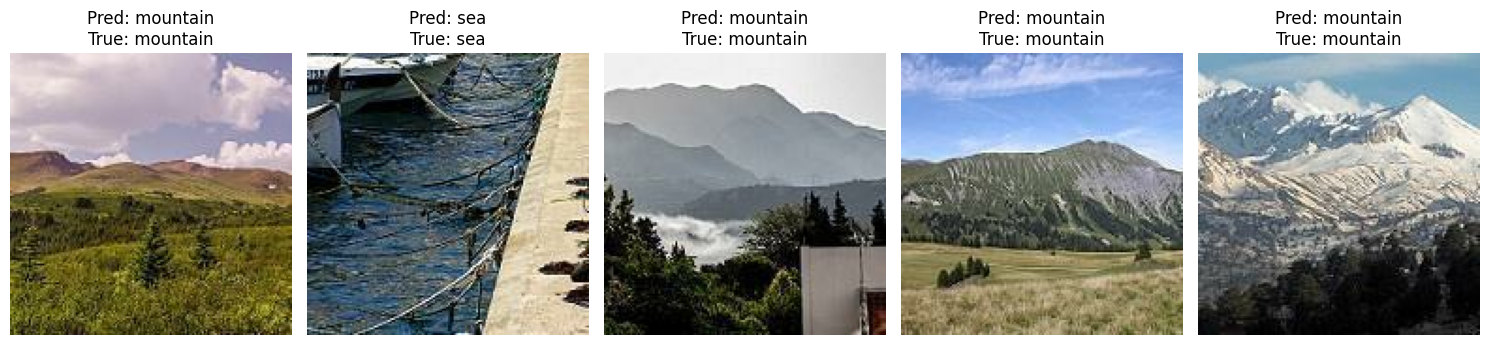

In [ ]:
val_acc_plot(history_full_base_model, epochs)

# Run evaluation on whole dataset
evaluate_model_on_test(full_base_model, test_ds, classes)

# Optionally visualize a few predictions
visualize_predictions(full_base_model, test_ds, classes)

## Comparing with Deeper model


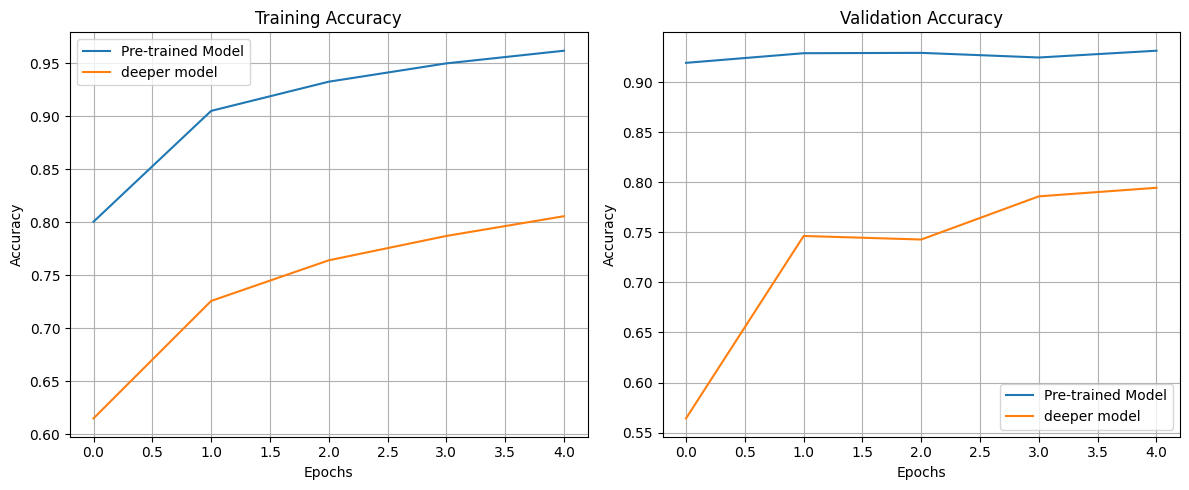

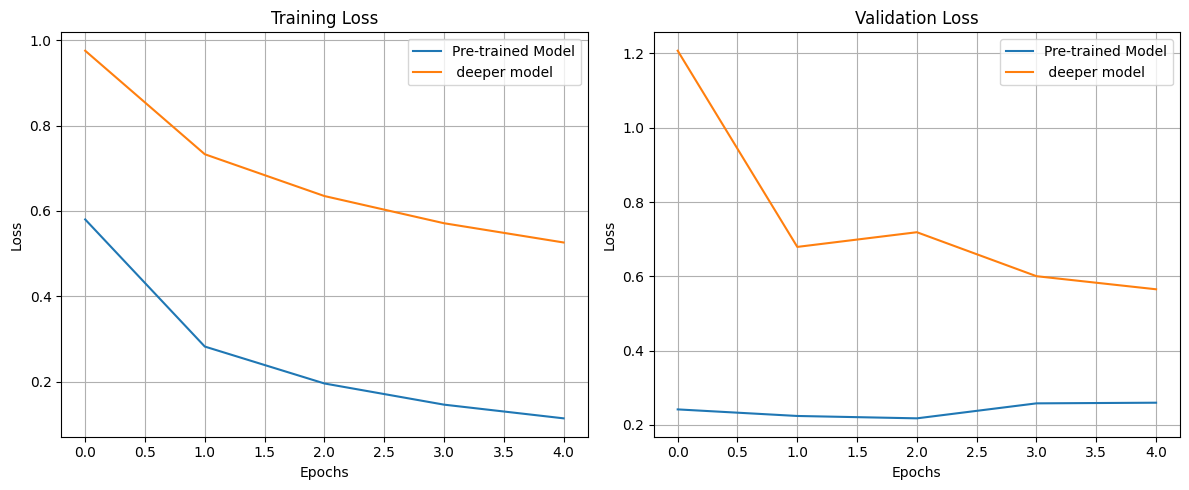

In [ ]:
compare_optimizers(first_model=history_full_base_model, second_model=deeper_model_history,labels=["Pre-trained Model", "deeper model"] , metric='accuracy')
compare_optimizers(first_model=history_full_base_model, second_model=deeper_model_history,labels=["Pre-trained Model", " deeper model"], metric='loss')

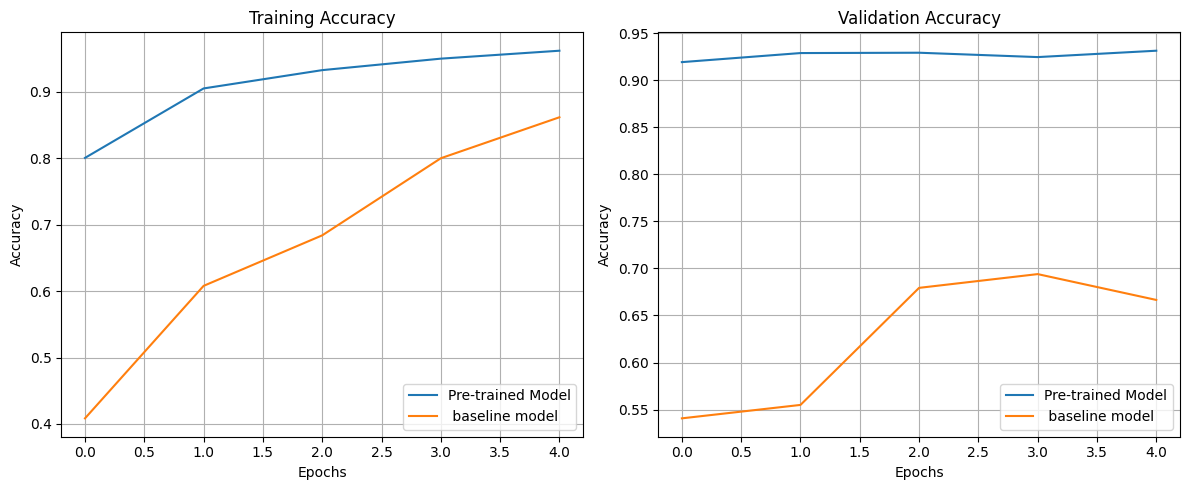

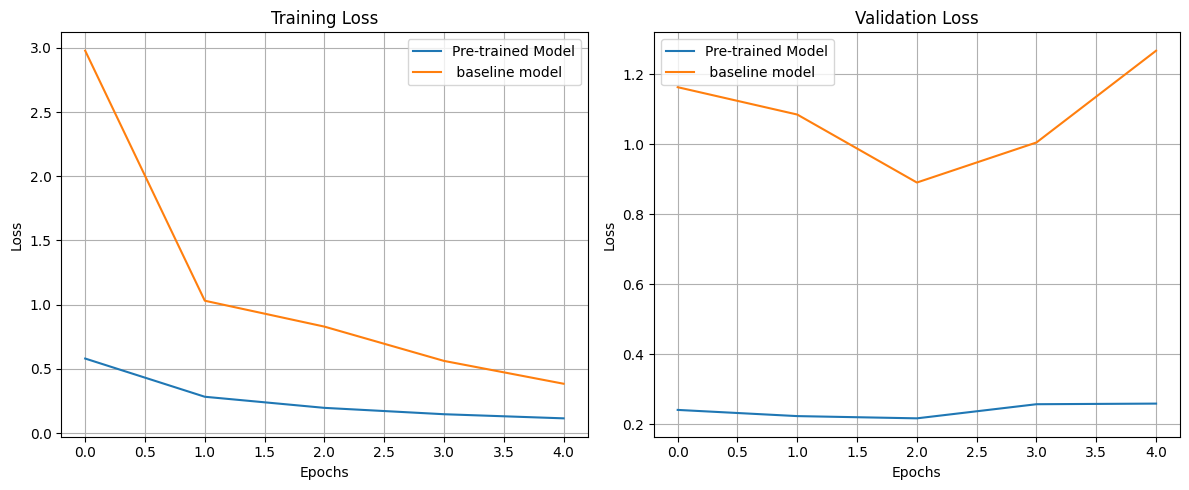

In [ ]:
compare_optimizers(first_model=history_full_base_model, second_model=history,labels=["Pre-trained Model", " baseline model"] , metric='accuracy')
compare_optimizers(first_model=history_full_base_model, second_model=history,labels=["Pre-trained Model", " baseline model"], metric='loss')

## Conclusion

we experimented with different ways to classify scene images using CNNs. Our Baseline CNN model provided a starting point but was not very accurate. The deeper CNN with regularization performed better but was computationally more expensive. The best performance was achieved using transfer learning with EfficientNetB0 with accuracy over 92.67%.